<h1 align="center">Haberman's Survival</h1>

Relevant Information:
   The dataset contains cases from a study that was conducted between
   1958 and 1970 at the University of Chicago's Billings Hospital on
   the survival of patients who had undergone surgery for breast
   cancer.

Number of Instances: 306

Number of Attributes: 4 (including the class attribute)

Attribute Information:

   1. Age of patient at time of operation (numerical)
   2. Patient's year of operation (year - 1900, numerical)
   3. Number of positive axillary nodes detected (numerical)
   4. Survival status (class attribute)
   
         * 1 = the patient survived 5 years or longer         
         * 2 = the patient died within 5 year
         
# Getting the Data

In [21]:
%pylab inline
pylab.style.use('ggplot')
import pandas as pd
import numpy as np
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [22]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/haberman/haberman.data'
data_df = pd.read_csv(url, header=None)

In [23]:
data_df.head()

,0,1,2,3
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


In [24]:
data_df.columns = ['age', 'year_of_op', 'n_nodes', 'survival']
data_df.head()

,age,year_of_op,n_nodes,survival
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


# Class Imbalance

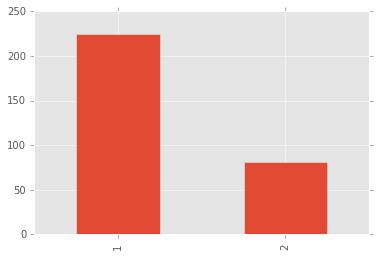

In [25]:
counts = data_df['survival'].value_counts()
counts.plot(kind='bar')

In [26]:
features = data_df.drop('survival', axis=1)
labels = data_df['survival']

# Feature Means for Both Classes

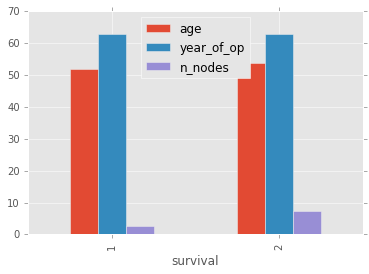

In [27]:
gp = features.groupby(labels)
f_means = gp.mean()
f_means.plot(kind='bar')

# Feature Stddev for Both Classes

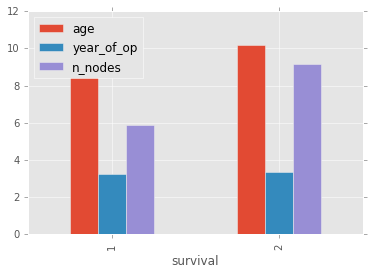

In [28]:
gp = features.groupby(labels)
f_std = gp.std()
f_std.plot(kind='bar')

# Distribution of Features with Classes

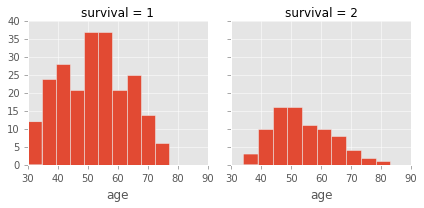

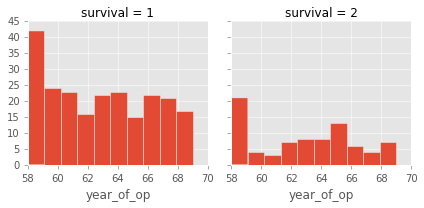

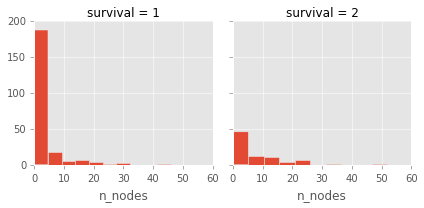

In [29]:
for colname in data_df.columns.drop('survival'):
    fg = sns.FacetGrid(col='survival', data=data_df)
    fg = fg.map(pylab.hist, colname)

# Feature Importances

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001809DFB9FD0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000001809E0A4198>], dtype=object)

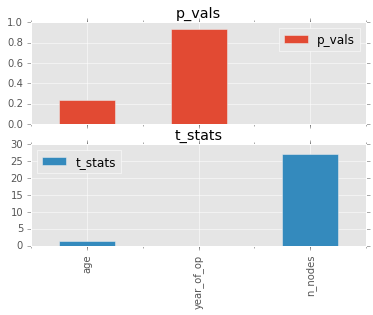

In [30]:
from sklearn.feature_selection import f_classif

t_stats, p_vals = f_classif(features, labels)
f_results = pd.DataFrame.from_dict({'t_stats': t_stats, 'p_vals': p_vals})
f_results.index = features.columns.copy()

f_results.plot(kind='bar', subplots=True)

# Model 1: Decision Tree Classifier

In [31]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

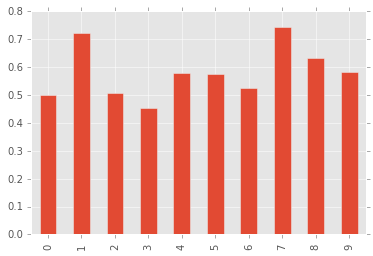

In [32]:
estimator = DecisionTreeClassifier()
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=12345)
dt_scores = cross_val_score(estimator, features, labels, cv=cv, scoring='f1_macro')

dt_scores = pd.Series(dt_scores)
dt_scores.plot(kind='bar')

# Visualizing Overfitting in the Decision Tree

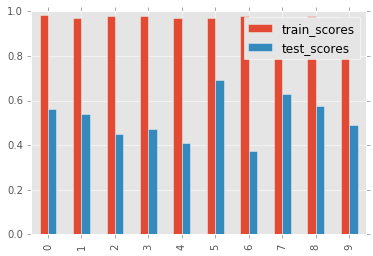

In [33]:
from sklearn.metrics import f1_score

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=12345)

def train_test_scores(train_index, test_index):
    """
    * Fit a DecisionTreeClassifier model on train data.
    * Calculate f1_score(s1) on predictions based on training data.
    * Calculate f1_score(s2) on predictions based on test data.
    * Return the 2-tuple(s1, s2)
    """
    train_features, train_labels = features.iloc[train_index], labels.iloc[train_index]
    test_features, test_labels = features.iloc[test_index], labels.iloc[test_index]
    
    model = DecisionTreeClassifier().fit(train_features, train_labels)    
    train_score = f1_score(train_labels, model.predict(train_features), average='macro')        
    test_score = f1_score(test_labels,  model.predict(test_features), average='macro')
    
    return (train_score, test_score)
    
scores = [train_test_scores(idx1, idx2) 
          for idx1, idx2 
          in cv.split(features, np.ones(len(features)))]

scores = pd.DataFrame.from_records(scores, columns=['train_scores', 'test_scores'])

scores.plot(kind='bar')

# Model 2: Gaussian Naive Bayes

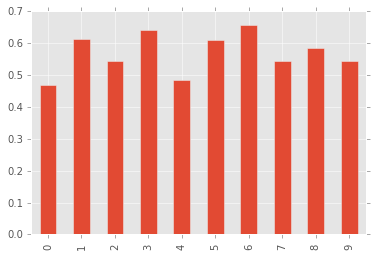

In [34]:
from sklearn.naive_bayes import GaussianNB

estimator = GaussianNB()
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=12345)
nb_scores_1 = cross_val_score(estimator, features, labels, cv=cv, scoring='f1_macro')

nb_scores_1 = pd.Series(nb_scores_1)
nb_scores_1.plot(kind='bar')

# Compare GaussianNB Scores with DT Scores

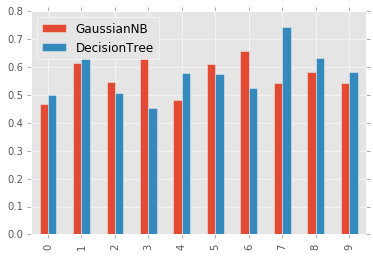

In [35]:
combined_scores = pd.concat([nb_scores_1, dt_scores], axis=1, keys=['GaussianNB', 'DecisionTree'])
combined_scores.plot(kind='bar')

In [36]:
combined_scores.mean(axis=0)

GaussianNB      0.568798
DecisionTree    0.581674
dtype: float64

# Model 3: GaussianNB with Equal Priors

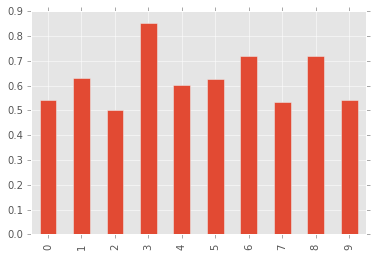

In [37]:
estimator = GaussianNB(priors=[0.5, 0.5])
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=12345)
nb_scores_2 = cross_val_score(estimator, features, labels, cv=cv, scoring='f1_macro')

nb_scores_2 = pd.Series(nb_scores_2)
nb_scores_2.plot(kind='bar')

In [38]:
nb_scores_2.mean()

0.6279709911647737

# McNemar's Test

# We have two models

* GaussianNB with non-equal priors

* GaussianNB with equal priors

Which one is the better model?

In [39]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=12345)

def calc_scores(train_index, test_index):
    """
    Return a `DataFrame` of two columns. Each column contains the predictions from two models, a `GaussianNB` 
    with equal priors and a `GaussianNB` with sample proportional priors.
    """
    train_features, train_labels = features.iloc[train_index], labels.iloc[train_index]
    test_features, test_labels = features.iloc[test_index], labels.iloc[test_index]
    
    model_1 = GaussianNB(priors=[0.5, 0.5])
    model_2 = GaussianNB()
    
    pred_1 = model_1.fit(train_features, train_labels).predict(test_features)    
    pred_2 = model_2.fit(train_features, train_labels).predict(test_features)
    
    return pd.DataFrame({'equal_priors': pred_1, 'proportional_priors': pred_2})

# Append all the runs from cross-validation
runs = [calc_scores(t1, t2)  for t1, t2 in cv.split(features, np.ones(len(features)))]
runs = pd.concat(runs, axis=0)

Now we can apply McNemar's test:

In [40]:
from statsmodels.sandbox.stats.runs import mcnemar

t_stat, p_val = mcnemar(runs['equal_priors'], runs['proportional_priors'])
print('t_stat from Mcnemar test: {:.2f}, p_val: {:.4f}'.format(t_stat, p_val))

t_stat from Mcnemar test: 0.00, p_val: 0.0000


Since the p-value is smaller than the significance level 0.05, we fail to reject the null hypothesis. So we can conclude that model 1 and model 2 are the same.